# Marketing Insights from Twitter Sentiment 

#### Zenith Mobile is an innovative startup poised to disrupt the mobile technology landscape by offering groundbreaking solutions that challenge the dominance of established brands. Instead of relying on traditional marketing avenues, Zenith Mobile's strategy is digital-first: identify potential customers active on social media, particularly those who feel lackluster about leading brands, and reach out to them directly. By doing this, they aim to create a direct dialogue with potential customers and showcase the unique advantages that Zenith Mobile has to offer.

#### To bring this strategy to life, I modeled sentiments from tweets related to big names in mobile tech, such as Apple and Google. I specifically worked with a compilation of 9,093 tweets about Apple or Google products. The tweets have been categorized based on sentiment: 2,978 are positive, 570 are negative, 5,389 are neutral, and 156 couldn't be determined. Since the goal is to pinpoint individuals who might be feeling indifferent or unsatisfied with the dominant brands, the positive class (labeled 1) was grouped to consist of all the neutral and negative sentiment tweets, for a total of 5,959 1's in the dataset. The negative class (labeled 0) consisted of all the positive sentiment tweets, for a total of 2,978 0's.  

#### I modeled the emotionality of the tweets using Natural Language Processing (NLP) in combination with several classifiers: Multinomial Naive Bayes, Logistic Regression, Random Forest, Neural Network, XGBoost, and Complement Naive Bayes. In running and tuning these models, we optimized for high recall scores to ensure that Zenith Mobile identifies as many likely potential customers as possible, minimizing the chances of missing out on someone who might be interested in their products.

#### After running baseline models for all the classifiers selected, Complement Naive Bayes, XGBoost, Random Forest, and Logistic Regression showed promise and were selected for further hyperparameter tuning. Following hyperparameter tuning, Complement Naive Bayes outperformed all other models with training, validation, and testing recall scores of 0.99, 0.98, and 0.98, respectively. 

In [1]:
# Switch to determine whether figures will be saved, 0=no, 1=yes
save_figs=0

In [25]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import WordNetLemmatizer, pos_tag

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, roc_curve, \
roc_auc_score, make_scorer, recall_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Download datasets and resources from NLTK
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/tem/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /Users/tem/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/tem/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/tem/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/tem/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /Users/tem/nltk_data...
[nltk_data]    |   Pack

True

## The Dataset
#### The data used in this study were sourced by CrowdFlower and are available on DataWorld (http://data.world). Below, I import the data and explore its attributes.

In [4]:
# Import data from csv
data = pd.read_csv('data/twitter-data.csv', encoding='latin1')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Check data for nans
data[data['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [6]:
# Drop nans and convert datatype in feature column
data['tweet_text'].dropna(inplace=True)
data['tweet_text'] = data['tweet_text'].astype(str)

In [7]:
# View value counts of target column
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(dropna=False)

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

#### The data has two columns of interest: 
- #### "tweet_text": contains the body of the tweet, which will make up our features
- #### "is_there_an_emotion_directed_at_a_brand_or_product": contains a judgement on the emotionality of the tweet, which will be our target. This column has 4 possible responses 1) No emotion toward brand or product, 2) Positive emotion, 3) Negative emotion, and 4) I can't tell. 

#### For simplicity, I will rename the target column so that it simply reads "emotion." I will also collapse the responses in that column to 0's and 1's, such that all tweets labeled "No emotion toward brand or product" or "Negative emotion" are grouped under 1 and all tweets labeled "Positive emotion" are grouped under 0. I am using this convention because our emotions of interest are neutral and negative. 

#### Note that tweets labeled "I can't tell" are excluded from the analysis. 

In [8]:
# Convert target column to 0's and 1's
data['emotion'] = data['is_there_an_emotion_directed_at_a_brand_or_product']
data.drop('is_there_an_emotion_directed_at_a_brand_or_product', axis = 1, inplace = True)

data = data[data['emotion'] != 'I can\'t tell'].reset_index(drop=True)
#data = data[data['emotion'] != 'No emotion toward brand or product'].reset_index(drop=True)

map_dict = {
    'No emotion toward brand or product': 1,
    'Positive emotion': 0,
    'Negative emotion': 1
}

data['emotion'] = data['emotion'].map(map_dict)

data

,tweet_text,emotion_in_tweet_is_directed_at,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,0
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,0
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,0
...,...,...,...
8932,Ipad everywhere. #SXSW {link},iPad,0
8933,"Wave, buzz... RT @mention We interrupt your re...",NaN,1
8934,"Google's Zeiger, a physician never reported po...",NaN,1
8935,Some Verizon iPhone customers complained their...,NaN,1


#### Next I split the data into training and testing sets. I will perform this split twice - once using the whole dataset, and once using a version of the dataset where the majority class (1's) are downsampled. This resampled data will come in handy when working with models that do not perform well with imbalanced datasets. 

In [9]:
# Define X and y
X = data['tweet_text']
y = data['emotion']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

In [10]:
# Downsample majority class to correct imbalance in dataset
zeros = data[data['emotion'] == 0]
ones_sampled = data[data['emotion'] == 1].sample(len(zeros), random_state=42)

data_rs = pd.concat([zeros, ones_sampled], axis=0)

X_rs = data_rs['tweet_text']
y_rs = data_rs['emotion']

X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X_rs, y_rs, test_size = 0.25, stratify = y_rs, random_state = 42)

#### Below, I define a class to preprocess the text data by completing the following steps:
- #### Case normalization
- #### Tokenization
- #### Part-of-speech tagging
- #### Lemmatization

In [11]:
# Create class to preprocess text data
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, data, y = 0):
        return self
    
    def transform(self, data, y = 0):
        fully_normalized_corpus = data.apply(self.process_doc)
        
        return fully_normalized_corpus
            
    def process_doc(self, doc):

        #initialize lemmatizer
        wnl = WordNetLemmatizer()
        stop_words = stopwords.words('english')
        
        # helper function to change nltk's part of speech tagging to a wordnet format
        def pos_tagger(nltk_tag):
            if nltk_tag.startswith('J'):
                return wordnet.ADJ
            elif nltk_tag.startswith('V'):
                return wordnet.VERB
            elif nltk_tag.startswith('N'):
                return wordnet.NOUN
            elif nltk_tag.startswith('R'):
                return wordnet.ADV
            else:         
                return None

        # remove punctuations, then lower case
        doc_norm = [tok.lower() for tok in word_tokenize(doc) if ((tok.isalpha()))]

        # creates list of tuples with tokens and POS tags in wordnet format
        wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(doc_norm))) 
        doc_norm = [wnl.lemmatize(token, pos) for token, pos in wordnet_tagged if pos is not None]

        return " ".join(doc_norm)

## Baseline Models

#### I begin the modeling process by passing the preprocessed data to 6 different machine learning models:      

- #### Multinomial Naive Bayes
- #### Logistic Regression
- #### Random Forest
- #### Neural Network
- #### XGBoost
- #### Complement Naive Bayes

#### Note that I fed the resampled dataset to the majority of these models (Multinomial Naive Bayes, Logistic Regression, Random Forest, Neural Network, and XGBoost) but fed the entire dataset to Complement Naive Bayes, since it is robust to imbalanced data. 

In [12]:
# Define and run baseline models on undersampled data
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer())
])

X_train_proc = pipeline.fit_transform(X_train)
X_test_proc = pipeline.transform(X_test)

X_train_rs_proc = pipeline.fit_transform(X_train_rs)
X_test_rs_proc = pipeline.transform(X_test_rs)

classifiers = {
    "MultinomialNB": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier()
}

recall_scores = {}

for name, clf in classifiers.items():
    clf.fit(X_train_rs_proc, y_train_rs)
    y_pred = clf.predict(X_test_rs_proc)
    recall_scores[name] = recall_score(y_test_rs, y_pred)

# Run ComplementNB on full dataset (not undersampled data)
clf = ComplementNB()
clf.fit(X_train_proc, y_train)
y_pred = clf.predict(X_test_proc)
recall_scores["ComplementNB*"] = recall_score(y_test, y_pred)

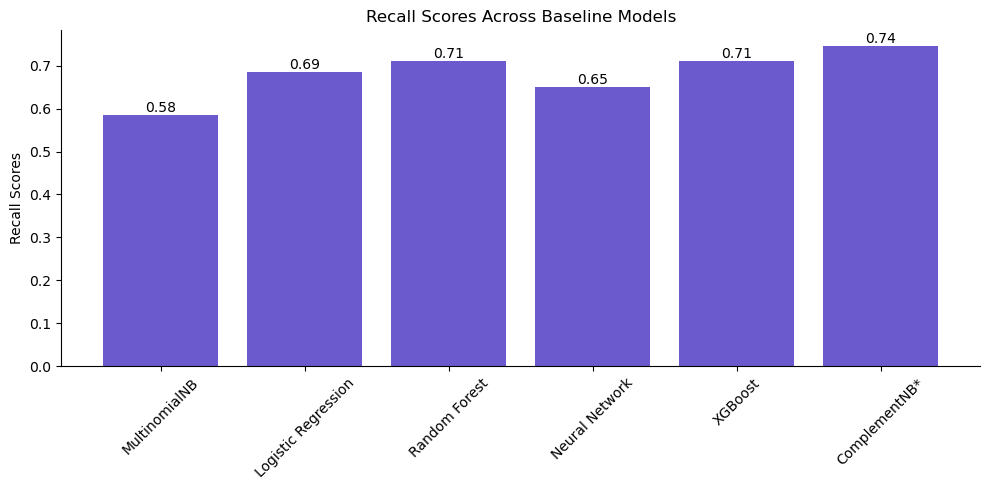

In [13]:
# Plot recall scores of baseline models
names = list(recall_scores.keys())
values = list(recall_scores.values())

plt.figure(figsize=(10, 5))
bars = plt.bar(names, values, color='#6A5ACD')
plt.ylabel('Recall Scores')
plt.title('Recall Scores Across Baseline Models')

# Annotate bars with recall scores
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()

if save_figs==1:
    plt.savefig('figs/baseline_recall_scores.png', dpi=300)

#### Of all the baseline models, Complement Naive Bayes performs the best with a recall score of 0.74. XGBoost, Random Forest, and Logistic Regression also perform reasonably well, with recall scores of 0.71, 0.71, and 0.69, respectively. For this reason, I will continue onto hyperparameter tune these top 4 performing models. 

In [14]:
# Create lists for the models to tune, the training recall scores for these models, and the testing recall scores for these models
tuned_models = ['ComplementNB*', 'XGBoost', 'Random Forest', 'Logistic Regression']
training_recalls = []
validation_recalls = []

In [15]:
# Define scorer for hyperparameter tuning
recall_scorer = make_scorer(recall_score, pos_label=1)

## Tune Complement Naive Bayes

In [16]:
# Hyperparameter tune Complement Naive Bayes
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', None),
    ('classifier', ComplementNB())
])

param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__min_df': [1e-10, 0.01, 0.05],
    'vectorizer__max_df': [0.85, 0.90, 0.99999],
    'classifier__alpha': [0.5, 1, 3, 5, 7],
    'classifier__fit_prior': [True, False]}

grid_search1 = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring=recall_scorer, return_train_score=True)
grid_search1.fit(X_train, y_train)

print("Best parameters found: ", grid_search1.best_params_)
print("Best vectorizer: ", grid_search1.best_estimator_.named_steps['vectorizer'])

best_index = grid_search1.best_index_
best_train_recall = grid_search1.cv_results_['mean_train_score'][best_index]
best_val_recall = grid_search1.cv_results_['mean_test_score'][best_index]

training_recalls.append(best_train_recall)
validation_recalls.append(best_val_recall)

print('')
print(f"Training Recall for Best Model: {best_train_recall:.4f}")
print(f"Validation Recall for Best Model: {best_val_recall:.4f}")

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters found:  {'classifier__alpha': 7, 'classifier__fit_prior': True, 'vectorizer': TfidfVectorizer(max_df=0.99999, min_df=1e-10), 'vectorizer__max_df': 0.99999, 'vectorizer__min_df': 1e-10}
Best vectorizer:  TfidfVectorizer(max_df=0.99999, min_df=1e-10)
Training Recall for Best Model: 0.9896
Validation Recall for Best Model: 0.9837


## Tune XGBoost

In [17]:
# Hyperparameter tune XGBoost
pipeline.steps.pop(-1)
pipeline.steps.append(('classifier', XGBClassifier()))

param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'classifier__learning_rate': [0.0001, 0.1, 0.5],
    'classifier__n_estimators': [10, 15, 50, 100, 200],
    'classifier__subsample': [0.5, 0.8],
    'classifier__max_depth': [3, 5, 7],
    'classifier__colsample_bytree': [0.8, 1.0]}

grid_search2 = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring=recall_scorer, return_train_score=True)
grid_search2.fit(X_train_rs, y_train_rs)

print("Best parameters found: ", grid_search2.best_params_)
print("Best vectorizer: ", grid_search2.best_estimator_.named_steps['vectorizer'])

best_index = grid_search2.best_index_
best_train_recall = grid_search2.cv_results_['mean_train_score'][best_index]
best_val_recall = grid_search2.cv_results_['mean_test_score'][best_index]

training_recalls.append(best_train_recall)
validation_recalls.append(best_val_recall)

print('')
print(f"Training Recall for Best Model: {best_train_recall:.4f}")
print(f"Validation Recall for Best Model: {best_val_recall:.4f}")

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters found:  {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.0001, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'vectorizer': CountVectorizer()}
Best vectorizer:  CountVectorizer()
Training Recall for Best Model: 0.7682
Validation Recall for Best Model: 0.7663


## Tune Random Forest

In [19]:
# Hyperparameter tune Random Forest
pipeline.steps.pop()
pipeline.steps.append(('classifier', RandomForestClassifier()))

param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'classifier__n_estimators': [100, 300],
    'classifier__max_depth': [10, 30, 50],
    'classifier__criterion': ['gini', 'entropy']}

grid_search3 = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring=recall_scorer, return_train_score=True)
grid_search3.fit(X_train_rs, y_train_rs)

print("Best parameters found: ", grid_search3.best_params_)
print("Best vectorizer: ", grid_search3.best_estimator_.named_steps['vectorizer'])

best_index = grid_search3.best_index_
best_train_recall = grid_search3.cv_results_['mean_train_score'][best_index]
best_val_recall = grid_search3.cv_results_['mean_test_score'][best_index]

training_recalls.append(best_train_recall)
validation_recalls.append(best_val_recall)

print('')
print(f"Training Recall for Best Model: {best_train_recall:.4f}")
print(f"Validation Recall for Best Model: {best_val_recall:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found:  {'classifier__criterion': 'entropy', 'classifier__max_depth': 50, 'classifier__n_estimators': 100, 'vectorizer': CountVectorizer()}
Best vectorizer:  CountVectorizer()
Training Recall for Best Model: 0.9455
Validation Recall for Best Model: 0.6831


## Tune Logistic Regression

In [21]:
# Hyperparameter tune Logistic Regression
pipeline.steps.pop()
pipeline.steps.append(('classifier', LogisticRegression()))

param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga']}

grid_search4 = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, scoring=recall_scorer, return_train_score=True)
grid_search4.fit(X_train_rs, y_train_rs)

print("Best parameters found: ", grid_search4.best_params_)
print("Best vectorizer: ", grid_search4.best_estimator_.named_steps['vectorizer'])

best_index = grid_search4.best_index_
best_train_recall = grid_search4.cv_results_['mean_train_score'][best_index]
best_val_recall = grid_search4.cv_results_['mean_test_score'][best_index]

training_recalls.append(best_train_recall)
validation_recalls.append(best_val_recall)

print('')
print(f"Training Recall for Best Model: {best_train_recall:.4f}")
print(f"Validation Recall for Best Model: {best_val_recall:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'vectorizer': TfidfVectorizer()}
Best vectorizer:  TfidfVectorizer()
Training Recall for Best Model: 0.7282
Validation Recall for Best Model: 0.7230


## Visualize hypertuned model performance

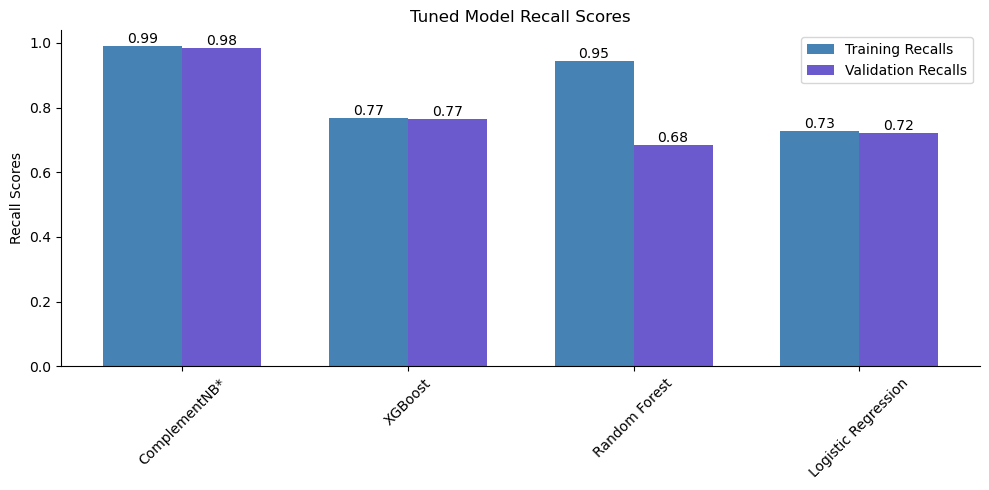

In [32]:
# Plot recall scores of training and testing sets for hyperparameter tuned models
bar_width = 0.35
index = np.arange(len(tuned_models))

plt.figure(figsize=(10, 5))

# Create bars
bars1 = plt.bar(index, training_recalls, bar_width, color='#4682B4', label='Training Recalls')
bars2 = plt.bar(index + bar_width, validation_recalls, bar_width, color='#6A5ACD', label='Validation Recalls')

# Annotate bars with training recall
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')

# Annotate bars with validation recall
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')

plt.ylabel('Recall Scores')
plt.title('Tuned Model Recall Scores')
plt.xticks(index + bar_width / 2, tuned_models, rotation=45)
plt.legend()
plt.tight_layout()
sns.despine()

if save_figs==1:
    plt.savefig('figs/tuned_recall_scores.png', dpi=300)

#### After hyperparameter tuning, the Complement Naive Bayes classifier performs exceptionally well, with training and validation recall scores approaching 1. The tuned random forest also performs well during training, but appears to be overfitting, as evidenced by the discrepancy between training and validation scores (recall = 0.95 for training, recall = 0.68 for testing). The tuned XGBoost and Logistic Regression classifiers do not perform much better than their baseline models. For these reasons, I select the Complement Naive Bayes classifier as the final model. To confirm this model selection, I will pass unseen data (the test set) to the Complement Naive Bayes classifier and assess recall scores.

## Final Model on Heldout Data

In [23]:
# Calculate model performance scores on test data using the best model (Complement Naive Bayes)
y_pred = grid_search1.best_estimator_.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.11      0.20       745
           1       0.69      0.98      0.81      1490

    accuracy                           0.69      2235
   macro avg       0.72      0.55      0.50      2235
weighted avg       0.71      0.69      0.61      2235



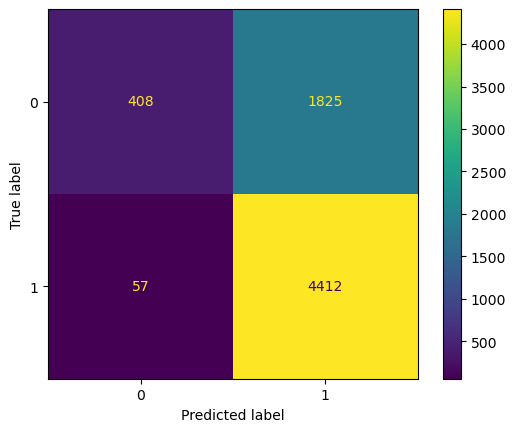

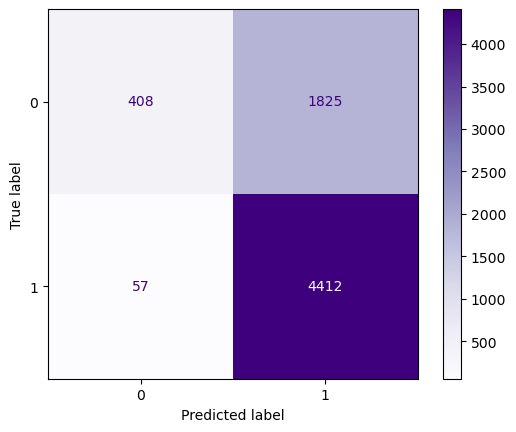

In [28]:
# Create a confusion matrix using the training data and the best model (Complement Naive Bayes)
disp = ConfusionMatrixDisplay.from_estimator(grid_search1.best_estimator_, X_train, y_train)
disp.plot(cmap='Purples')

if save_figs==1:
    plt.savefig('figs/conmat_train.png', dpi=300)

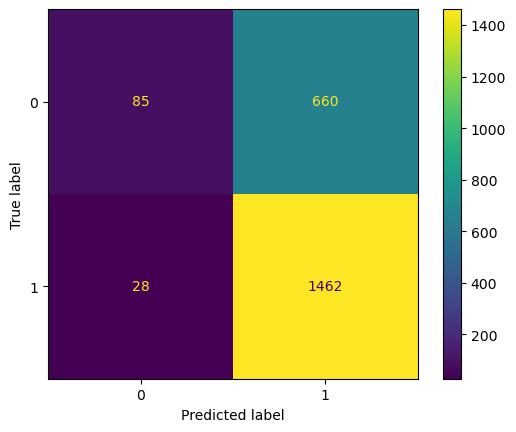

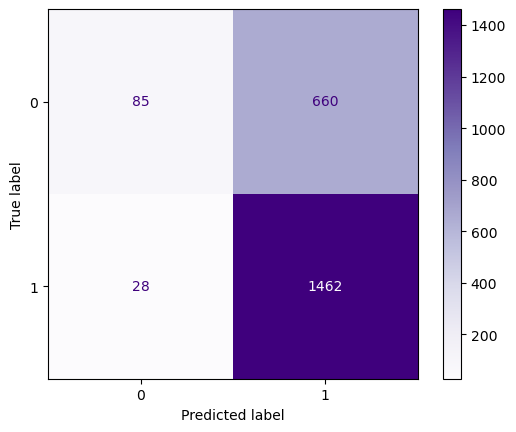

In [34]:
# Create a confusion matrix using the testing data and the best model (Complement Naive Bayes)
disp = ConfusionMatrixDisplay.from_estimator(grid_search1.best_estimator_, X_test, y_test)
disp.plot(cmap='Purples')

if save_figs==1:
    plt.savefig('figs/conmat_test.png', dpi=300)

### Conclusions: 
- #### We are able to successfully classify tweets based on emotionality with high model performance scores.
- #### A Complement Naive Bayes classifier outperforms all other models tested, and gives the added benefit of managing the entire, imbalanced dataset.
- #### The final model achieves high recall (0.98), although sacrifices precision (0.69)